## Import all packages and module

In [15]:
import casadi as cs
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from lglpsmethods import LGL

## use symbolic casadi variables to create state and control vectors

In [16]:
Nx = 2
Nu = 1
x = cs.MX.sym("x", Nx, 1)
u = cs.MX.sym("u", Nu, 1)

## create functions of the optimal control problem (Lagrange term, dynamics)

In [17]:
L = u**2
L = cs.Function('L', [x, u], [L])

f = cs.vcat([x[1], -x[1]+u])
f = cs.Function('L', [x, u], [f])

x_t0 = cs.DM.zeros(2, 1)
a, b = (2.694528, 1.155356)

## create pseudospectral grid and compute the differentiation matrices and quadratures

In [18]:
t0 = 0
tf = 2
N = 30
dt = (tf-t0)/N
T=tf-t0
ps=LGL(N+1)
D=ps.D
tau=ps.tau
wi=ps.wi
t=(tf-t0)/2*tau+(tf+t0)/2

In [19]:
## create NLP using Opti() class

In [20]:
nlp = cs.Opti()
X = nlp.variable(Nx, N+1)
U = nlp.variable(Nu, N+1)

## transcribe the optimal control problem

In [21]:
cs_type = Union[cs.MX, cs.SX, cs.DM]
def obj_int(wi,T: cs_type, xv: cs_type, uv: cs_type, L: cs.Function):

    return T/2*cs.dot(L(xv, uv),wi.T)
 
def dyn_int(D,T: cs_type, xv: cs_type, uv: cs_type, f: cs.Function):

    return cs.vec(2/T*(D@X.T).T-f(xv, uv))

obj_L = obj_int(wi,T,X,U,L)
obj_E = 0 # mayer term
res = dyn_int(D,T, X, U, f)

## solve the optimization problem using IPOPT

In [22]:
nlp.minimize(obj_L+obj_E)
nlp.subject_to(X[:, 0]-x_t0 == 0)
nlp.subject_to(res == 0)
nlp.subject_to(X[0, N]-a*X[1, N]+b == 0)
nlp.solver('ipopt')
sol=nlp.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1988
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       31

Total number of variables............................:       93
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       65
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.16e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

## analytical solution

In [23]:
t=(t.flatten())
us=np.exp(t)/4-1/2
z1s=-3/8*np.exp(-t)+np.exp(t)/8-1/2*t+1/4
z2s=3/8*np.exp(-t)+1/8*np.exp(t)-1/2
Js=1/32*(8*2-8*np.exp(2)+np.exp(2*2))-1/32*(8*0-8*np.exp(0)+np.exp(2*0))
print('Optimal objective error (|Analytical-Numerical|)--',np.abs(Js-sol.value(nlp.f)))

Optimal objective error (|Analytical-Numerical|)-- 3.0414078400209377e-07


## plots

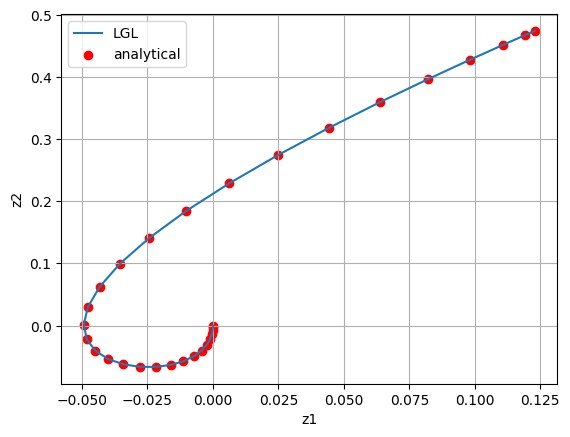

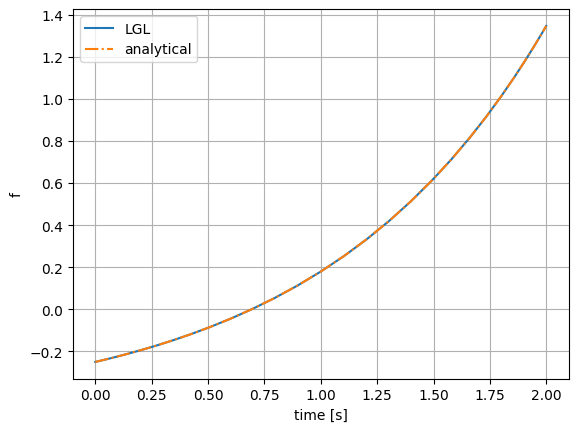

In [24]:
plt.plot(sol.value(X[0,:]),sol.value(X[1,:]),label='LGL')
plt.scatter(z1s,z2s,label='analytical',c='r')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
plt.grid()
plt.show()
plt.figure()
plt.plot(t,sol.value(U),label='LGL')
plt.plot(t,us,label='analytical',ls='-.')
plt.xlabel('time [s]')
plt.ylabel('f')
plt.legend()
plt.grid()
plt.show()